In [19]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data_dir = "/workspace/PythonProjects/cityscapes_segmentation_tf2/SUN397"

In [3]:
def get_image_list(img_pattern='*.jpg'):
    
    letter = '*'
    category = '*'
    
    search_image_files1 = os.path.join(data_dir, letter,category, img_pattern)
    search_image_files2 = os.path.join(data_dir, letter,category,'*', img_pattern)

    image_list1 = glob.glob(search_image_files1)
    
    image_list2 = glob.glob(search_image_files2)
    
    print("Found {} files with search pattern {}".format(len(image_list1), search_image_files1))
    print("Found {} files with search pattern {}".format(len(image_list2), search_image_files2))
    
    image_list = image_list1 + image_list2
    print("Total: {} images".format(len(image_list)))
    
    np.random.shuffle(image_list)
    
    return image_list


def parse_label(x):
    x = x.split('/')[6]
    return x


def get_labels(img_list):
    label_list = []
    for i in range(0, len(img_list)):
        label_list.append(parse_label(img_list[i]))
    print("Total: {} labels with {} categories".format(len(label_list), len(set(label_list))))
    
    label_dict = dict(zip(set(label_list), [i for i in range(0, len(label_list))]))
    
    label_encodings = []
    for i in range(0, len(label_list)):
        label_encodings.append(label_dict[label_list[i]])
    
    return label_encodings


def get_class_names_list(fp):
    class_names = []
    with open(os.path.join(data_dir, 'ClassName.txt')) as f:
        for line in f:
            class_names.append(line.split('/')[2].rstrip('\n'))
    f.close()
    return list(set(class_names))


def filter_images(image_list):
    
    filtered_image_list = []
    
    for i in range(0, len(image_list)):
        
        if i%100 == 0:
            print("\rChecking {} / {}".format(i, len(image_list)), end='')
            
        read_img = True
        
        img = tf.io.read_file(image_list[i])
        
        try:
            img = tf.image.decode_png(img, channels=3)
        except:
            read_img = False
            
        if read_img:
            filtered_image_list.append(image_list[i])
        
    return filtered_image_list

In [4]:
image_list = get_image_list(img_pattern='*.jpg')

Found 78457 files with search pattern /workspace/PythonProjects/cityscapes_segmentation_tf2/SUN397/*/*/*.jpg
Found 30297 files with search pattern /workspace/PythonProjects/cityscapes_segmentation_tf2/SUN397/*/*/*/*.jpg
Total: 108754 images


In [5]:
label_list = get_labels(image_list)

Total: 108754 labels with 362 categories


In [9]:
n_classes = 362
DATASET_LENGTH = len(image_list)
TRAIN_LENGTH = int(DATASET_LENGTH * 0.8)
img_height=512
img_width=512

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((image_list[:TRAIN_LENGTH], label_list[:TRAIN_LENGTH]))
test_ds = tf.data.Dataset.from_tensor_slices((image_list[TRAIN_LENGTH:], label_list[TRAIN_LENGTH:]))

In [15]:
def load_image_train(image_path, label, flip=0):
    img = tf.io.read_file(image_path)

    img = tf.cast(tf.image.decode_png(img, channels=3), dtype=tf.float32)
    img = tf.image.resize(images=img, size=[img_height, img_width])
    img = tf.image.random_brightness(img, max_delta=50.)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.clip_by_value(img, 0, 255)
    img = tf.case([(tf.greater(flip, 0), lambda: tf.image.flip_left_right(img))], default=lambda: img)
    # img = img[:, :, ::-1] - tf.constant([103.939, 116.779, 123.68])
    img = img / 255.0
    
    label = tf.one_hot(tf.cast(label, tf.int32), n_classes)
    
    return img, label


def load_image_test(image_path, label, flip=0):
    img = tf.io.read_file(image_path)

    img = tf.cast(tf.image.decode_png(img, channels=3), dtype=tf.float32)
    img = tf.image.resize(images=img, size=[img_height, img_width])
    img = tf.clip_by_value(img, 0, 255)
    # img = img[:, :, ::-1] - tf.constant([103.939, 116.779, 123.68])
    img = img / 255.0
    
    label = tf.one_hot(tf.cast(label, tf.int32), n_classes)
    
    return img, label


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image_test)

In [21]:
for image, mask in test.take(1): # 16
    sample_image, sample_mask = image, mask

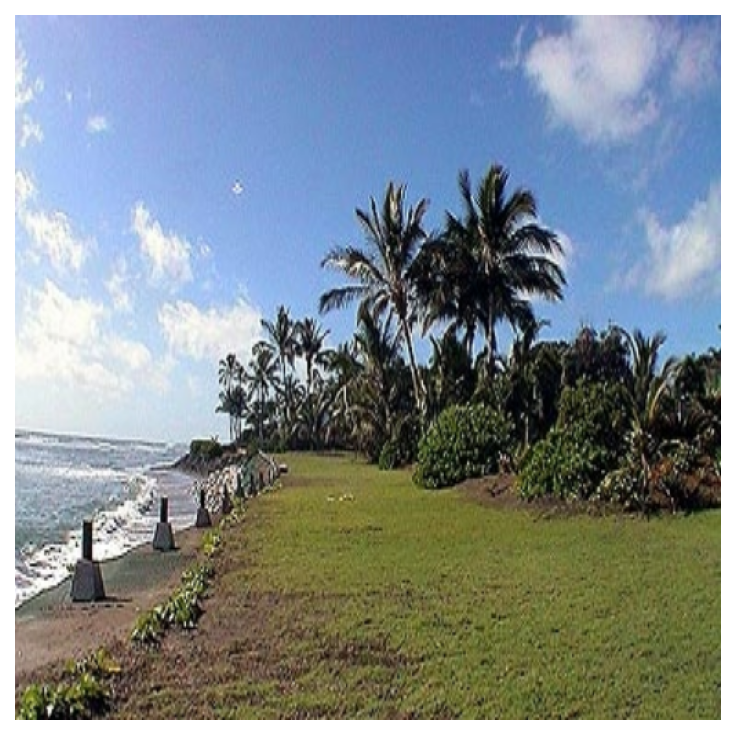

In [22]:
display([sample_image])